In [2]:
import statistics

In [3]:
import numpy as np
import pandas as pd
import math
from operator import itemgetter

import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def distancia_euc(lat1, lon1, lat2, lon2):
    p = math.pi/180
    a = 0.5 - math.cos((lat2-lat1)*p)/2 + math.cos(lat1*p) * math.cos(lat2*p) * (1-math.cos((lon2-lon1)*p))/2
    d = 12742 * math.asin(math.sqrt(a))
    return  d

In [5]:
#Leer archivos json
centroides_ideal = open('C:/Users/oscar/Documents/IronHack/Final project/kmedians_experiment_1/centroides_clusters_kmedians_120_200.json')
centroides_ideal = json.load(centroides_ideal)
centroides_ideal_2 = open('C:/Users/oscar/Documents/IronHack/Final project/kmedians_experiment_1/centroides_clusters_kmedians_50_110.json')
centroides_ideal_2 = json.load(centroides_ideal_2)
centroides_final = {**centroides_ideal_2,**centroides_ideal}

In [6]:
#Leer ubicaciones de casetas de policía
ubicaciones_seguridad = pd.read_csv('servicios_y_sedes_fgj.csv',encoding = "ISO-8859-1")
ubicaciones_limpio = ubicaciones_seguridad.loc[:,['sede','latitude','longitude']]

In [7]:
# Obtener centroides desplazados.
centroides_desplazados = dict()
for k,centroides_ideal in centroides_final.items():
    centroides_ideal_df = pd.DataFrame(centroides_ideal)
    centroides_ideal_df = centroides_ideal_df.T
    min_vector_cluster = dict()
    for i in range(len(centroides_ideal_df)):
        punto_mas_cercano = 1000
        ubicacion_mas_cercana = [0,0]
        for cluster in range(len(ubicaciones_limpio)):
            distancia = distancia_euc(centroides_ideal_df.iloc[i,1], centroides_ideal_df.iloc[i,0], ubicaciones_limpio.loc[cluster,'latitude'], ubicaciones_limpio.loc[cluster,'longitude'])
            if distancia < punto_mas_cercano:
                punto_mas_cercano = distancia
                ubicacion_mas_cercana[0] = ubicaciones_limpio.loc[cluster,'longitude'], ubicaciones_limpio.loc[cluster,'latitude']   
        min_vector_cluster[i] = [ubicacion_mas_cercana[0],punto_mas_cercano]
    centroide_cluster = {k:v[0] for (k,v) in min_vector_cluster.items()}
    centroides_desplazados[k]= centroide_cluster

In [8]:
# Calcular todas las distancias .
dist_centroides_puntos = dict()

for n_k,centroide_cluster in centroides_desplazados.items():
    data_delitos_kmed = pd.read_csv("C:/Users/oscar/Documents/IronHack/Final project/kmedians_experiment_1/data_delitos_kmed{}.csv".format(n_k))
    X = data_delitos_kmed.loc[:,['longitud','latitud','kmedians_labels']]
    distancias_cluster = dict()

    for cluster in list(set(X['kmedians_labels'])):
            dist_list = []
            for i in zip(X[X['kmedians_labels']==cluster].loc[:,'longitud'],X[X['kmedians_labels']==cluster].loc[:,'latitud']):
                    dist_list.append(distancia_euc(centroide_cluster[cluster][1],centroide_cluster[cluster][0],i[1],i[0]))
            distancias_cluster[cluster] = dist_list
    dist_centroides_puntos[n_k] = distancias_cluster

In [10]:
dist_centroides_puntos['50']

{0: [2.7170579365460403,
  0.9851755657099813,
  0.5177845868556822,
  0.48850103900594544,
  3.0554107802857917,
  2.32213118738642,
  1.5639043925197933,
  3.1421980697299294,
  2.6688904223376673,
  2.2021448556647196,
  0.1565198401418037,
  1.5313722943466295,
  3.02505236357695,
  1.4861910359499055,
  1.4127615571640522,
  1.8826257357734988,
  1.8162943130102813,
  1.4335327024294955,
  1.3031971531939102,
  2.2803181730676307,
  1.8470944738725477,
  1.5479978405998303,
  1.5130021947801644,
  1.1469126750480092,
  1.2840348521669138,
  1.73418483515674,
  1.7719047413752163,
  1.1809019943118095,
  0.8820146373652993,
  2.540267445478974,
  2.931691273182591,
  1.4173609748918137,
  0.7984352982053456,
  1.8260412468795957,
  1.8131369102085722,
  1.8695469473383133,
  2.1405614872197485,
  3.1396186170218816,
  1.348745638391981,
  2.815504588503539,
  2.439857593753778,
  1.2226428512861376,
  3.4190572830052464,
  2.1198405365625477,
  1.2953678121773076,
  0.2688275390818

In [11]:
#Calcular la mediana de la respuesta para cada número clústeres.
resultados = dict()
for n_k,cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in cluster:
        lista_distancias = lista_distancias + cluster[i]
    resultados[n_k]= statistics.median(lista_distancias)

In [18]:
#Cambiar resultados a tiempo.
resultados_tiempos = {int(k):(((v/61.2)*3600)+10) for k,v in resultados.items()}

In [19]:
resultados_tiempos

{50: 97.48423076050672,
 60: 89.71522045798396,
 70: 84.3900337611618,
 80: 80.09849185521037,
 90: 74.22944774004411,
 100: 73.57089337499312,
 110: 70.59734249759947,
 120: 68.26272483139144,
 130: 66.45712235913695,
 140: 63.9553571673335,
 150: 64.04045960958035,
 160: 62.302553716680904,
 170: 63.13382417790286,
 180: 60.919665921679155,
 190: 59.220190386674815,
 200: 58.271403114329644}

In [23]:
resultados_tiempos_df = pd.DataFrame(resultados_tiempos,index=[0])

In [27]:
resultados_tiempos_df = resultados_tiempos_df.T

In [28]:
resultados_tiempos_df.to_excel('resultados_kmeans200.xlsx')

Text(0, 0.5, 'Tiempo de respuesta máximo (segundos)')

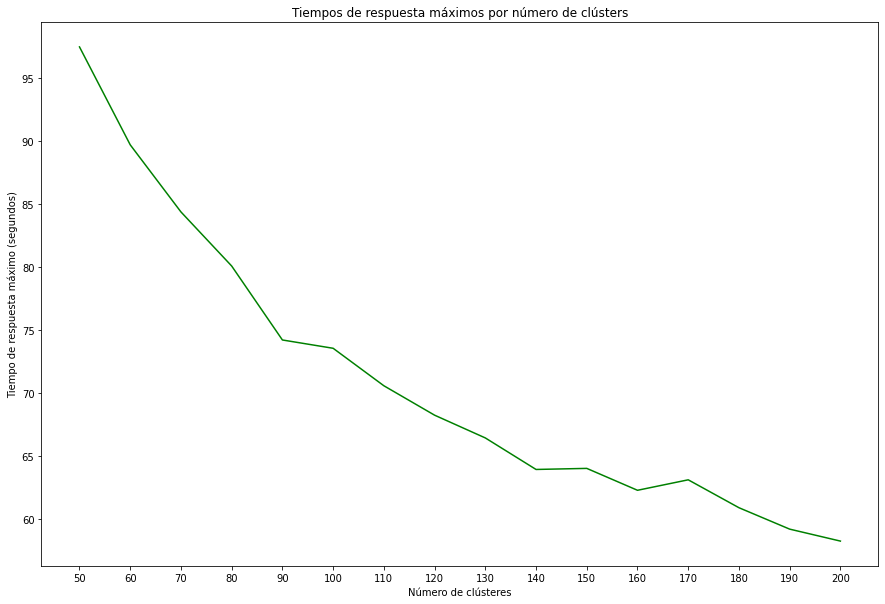

In [14]:
plt.figure(figsize=(15,10))
plt.plot(list(resultados_tiempos.keys()),list(resultados_tiempos.values()),color='green')
plt.title('Tiempos de respuesta máximos por número de clústers')
plt.xlabel('Número de clústeres')
plt.ylabel('Tiempo de respuesta máximo (segundos)')

In [32]:
#Calcular el radio máximo al 95% de significancia para cada n_k.
resultados_95 = dict()
for n_k,radio_cluster in dist_centroides_puntos.items():
    lista_distancias = []
    for i in radio_cluster.values():
        lista_distancias = lista_distancias + i
    perc_95 = np.percentile(lista_distancias,95)
    radio_max = 0
    for radio in lista_distancias:
        if radio <= perc_95 and radio > radio_max:
            radio_max = radio
    resultados_95[n_k]= radio_max

In [33]:
#Cambiar resultados a tiempo.
resultados_tiempos_95 = {int(k):(((v/61.2)*3600)+10) for k,v in resultados_95.items()}

In [34]:
resultados_tiempos_95

{50: 190.11509557482393,
 60: 184.43682128975752,
 70: 167.31260605206663,
 80: 159.0959607398616,
 90: 148.93295856782115,
 100: 145.45838508551185,
 110: 140.03612053183156,
 120: 139.49915336760932,
 130: 131.8153076204129,
 140: 128.15084090406236,
 150: 131.96560198133005,
 160: 123.87610861848798,
 170: 129.96922654997178,
 180: 124.5515956280199,
 190: 122.4204745551658,
 200: 119.1363823108785}

In [15]:
# Calcular distancias max.
radio_clusters = dict()

for n_k,centroide_cluster in centroides_desplazados.items():
    data_delitos_kmed = pd.read_csv("C:/Users/oscar/Documents/IronHack/Final project/kmedians_experiment_1/data_delitos_kmed{}.csv".format(n_k))
    X = data_delitos_kmed.loc[:,['longitud','latitud','kmedians_labels']]
    max_vector_cluster = dict()

    for cluster in list(set(X['kmedians_labels'])):
            vector_list = []
            for i in zip(X[X['kmedians_labels']==cluster].loc[:,'longitud'],X[X['kmedians_labels']==cluster].loc[:,'latitud']):
                    vector_list.append((i,np.linalg.norm(np.subtract(i,centroide_cluster[cluster]))))
            max_vector_cluster[cluster] = max(vector_list, key=itemgetter(1))[0]
    
    radio_clusters[n_k] = [distancia_euc(centroide_cluster[cluster][1],centroide_cluster[cluster][0],max_vector_cluster[i][1],max_vector_cluster[i][0]) for i in set(X['kmedians_labels'])]
    

In [115]:
#Calcular la mediana de la respuesta en cada cluster.
resultados = dict()
for n_k,radio_cluster in radio_clusters.items():
    resultados[n_k]= statistics.median(radio_cluster)

In [51]:
for n_k in centroides_desplazados.keys():
    centroides_desplazados_df['latitud_{}'.format(n_k)] = centroides_desplazados_df[n_k].apply(evalua_latitud)
    centroides_desplazados_df['longitud_{}'.format(n_k)] = centroides_desplazados_df[n_k].apply(evalua_longitud)

AttributeError: 'tuple' object has no attribute 'notna'